# MBTI Project

By The Introverts 

In [1]:
reset -fs

In [2]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import re
from collections import Counter
import numpy as np

## The Data
#### Personality types:
* extroversion vs. introversion
* intuition vs. sensing
* thinking vs. feeling
* judging vs. perceiving


In [3]:
mbti = pd.read_csv('data/mbti_1.csv') # Original Dataframe
mbti_clean = mbti.copy() # Dataframe to be cleaned 
mbti_features = mbti.copy() # Dataframe to be populated with features
mbti_features.drop(columns=['posts'],inplace=True)

## General Cleaning

**Removing Links:**

Remove all triple pipes because some links end at the end of a post which making it hard to find with regex. 

In [4]:
# For each user, remove ||| to make it easier to remove links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Remove all links. 
linkless_posts = [re.sub(r'http[\S]* ','',posts) for posts in user_posts]
# Update mbti_clean 
mbti_clean['posts'] = linkless_posts

**Lower Case**:

In [5]:
# Set all user posts to lowercase 
mbti_clean['posts'] = mbti_clean['posts'].str.lower()

# General info:
#### Personality Types:

In [6]:
# glance at the distribution of personality types
mbti['type'].value_counts()  # most common personality: INFP

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [7]:
# Types per category
# analyze types by sub-category may be easier
mbti['EorI']= mbti['type'].apply(lambda x:x[0])
mbti['NorS']= mbti['type'].apply(lambda x:x[1])
mbti['TorF']= mbti['type'].apply(lambda x:x[2])
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

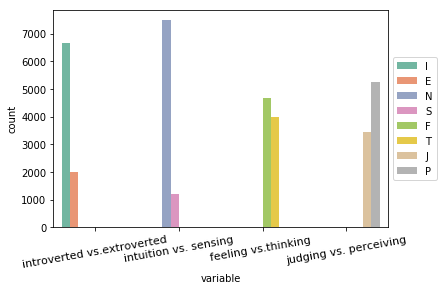

In [11]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Imbalanced class: I vs E, N vs S. Some advanced techniques like resampling methods may be needed later to handle imbalanced classes.

# Word Count 
# START WORKING HERE

Strip all punctuations and numbers:

In [13]:
# Strip all punctuation. Returns a list of strings 
posts_without_punct = [re.sub(r'[^a-z\s]','',posts) for posts in mbti_clean['posts']]
# Split each element in the list into a list of words. Returns a list of lists 
words = [posts.split() for posts in posts_without_punct]

Stem words, remove stop words, and remove words less than 3 characters in length.

**Caution:** Takes a few minutes to run

In [15]:
## CAUTION: STEMMING WORDS TAKES A FEW MINUTES. UNCOMMENT TO RE-RUN
# Stem words, remove stop words and words less than 3 characters
stemmer = PorterStemmer()
for row in range(len(words)):
#     bar.next()  
# ^ gives an error
    words[row] = " ".join([stemmer.stem(word) for word in words[row] if word not in list(stop_words.ENGLISH_STOP_WORDS) and len(word) >= 3])


Create a bag of words representation of each user 

In [9]:
# Chose CountVectorizer with min_df = 25 because there were some odd cases like 'aaaaa' 
vectorizer = CountVectorizer(min_df=25)
word_count = vectorizer.fit_transform(words)
# Create word_count dataframe 
word_count_df = pd.DataFrame(data = word_count.toarray(), columns = vectorizer.get_feature_names())
word_count_df.head()

AttributeError: 'list' object has no attribute 'lower'

## Sentiment Score 

**Caution:** Takes a few minutes to run

In [10]:
scores = []
for i in range(len(posts_without_punct)):
    score = analyzer.polarity_scores(posts_without_punct[i])['compound']
    scores.append(score)
    # Print Progress 
    if i%200 == 0:
        print(i)

NameError: name 'analyzer' is not defined

In [ ]:
pd.Series(scores).describe()

## Ellipses Count

Counting number of ellipsies used per user.

In [ ]:
# Create a list of ellpsies count per user. This is an indicator for long posts 
ellipses_count = [len(re.findall(r'\.\.\.',posts)) for posts in mbti_clean['posts']]
# Append to dataset 
mbti_features['ellipses'] = ellipses_count

## Exclamation Count
Counting number of exclamation marks used per user. 

In [ ]:
# Create a list of exclamation count per user. 
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti_clean['posts']]
# Append to features dataframe
mbti_features['exclamation'] = exclamation_count

## Question Count
Counting number of question marks used per user. 

In [13]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in mbti_clean['posts']]
# Append to features dataframe
mbti_features['question'] = question_count

8675

## Link Count 
Counting number of links used per user. 

In [ ]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Create a list of link count per user. 
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
# Append to features dataframe
mbti_features['links'] = link_count

## Additional Features to Consider:

* Sentence Length
* N grams (or is this more of a step tuning with count vectorizer? 